# Reproducibility of steady-states data

**Author:** M.G. Baltussen & T.J. de Jong

**Estimated running time:** 2 minutes

**Generated output:**
```
plots_extended/steadystates_reproducibility.{svg,png}
```

In [1]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.75, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


In [2]:
df_all = pd.read_csv("../data/steadystates.csv", index_col=0)

label_map = pd.read_csv("../data/compound_label_map.csv",names=["compound","composition"])

label_dict = dict(zip(label_map["compound"],label_map["composition"]))
df_all = df_all.rename(columns=label_dict)

# df_all = pd.melt(df_all, id_vars=["time", "NaOH", "Form", "exp"], var_name="compound", value_name="Intensity")
df_all

,time,NaOH,Form,$[C_{10}H_{22}O_{11}Ca]^{2+}$ I1,$[C_{10}H_{22}O_{11}Ca]^{2+}$ I2,$[C_{10}H_{22}O_{11}Ca]^{2+}$ I3,$[C_{10}H_{20}O_{10}Ca]^{2+}$ I1,$[C_{10}H_{20}O_{10}Ca]^{2+}$ I2,$[C_{10}H_{20}O_{10}Ca]^{2+}$ I3,$[C_{10}H_{20}O_{10}Ca]^{2+}$ I4,...,$[C_{9}H_{18}O_{7}Ca]^{2+}$ I4,$[C_{9}H_{18}O_{8}Ca]^{2+}$ I1,$[C_{9}H_{18}O_{8}Ca]^{2+}$ I2,$[C_{9}H_{18}O_{8}Ca]^{2+}$ I3,$[C_{9}H_{18}O_{8}Ca]^{2+}$ I4,$[C_{9}H_{18}O_{9}Ca]^{2+}$ I1,$[C_{9}H_{18}O_{9}Ca]^{2+}$ I2,$[C_{9}H_{18}O_{9}Ca]^{2+}$ I3,$[C_{9}H_{18}O_{9}Ca]^{2+}$ I4,exp
1,3260.0,27.2896,90.2669,0.004688,0.006608,0.000261,0.005009,0.024014,0.000248,0.000506,...,0.000211,0.000346,0.001681,0.005278,0.000299,0.002147,0.012317,0.062326,0.010031,FTT008
2,5060.0,30.6315,96.6331,0.004755,0.005385,0.000320,0.005124,0.020682,0.000283,0.000617,...,0.000258,0.000407,0.001698,0.005388,0.000384,0.001705,0.008822,0.050782,0.007037,FTT008
3,6860.0,21.8414,100.4384,0.004011,0.007913,0.000197,0.004291,0.025851,0.000195,0.000316,...,0.000173,0.000307,0.002028,0.005151,0.000241,0.003283,0.020522,0.072326,0.015602,FTT008
4,8660.0,12.6292,109.9410,0.002072,0.007689,0.000125,0.003511,0.022602,0.000154,0.000189,...,0.000111,0.000225,0.002092,0.003368,0.000153,0.007551,0.036703,0.069206,0.023238,FTT008
5,10460.0,20.0000,115.0000,0.003669,0.008127,0.000167,0.004635,0.027377,0.000188,0.000281,...,0.000144,0.000279,0.002081,0.004430,0.000217,0.004870,0.029162,0.080224,0.017172,FTT008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,18300.0,31.6440,148.5580,0.004468,0.004894,0.000326,0.004695,0.018131,0.000268,0.000719,...,0.000253,0.000348,0.001677,0.004860,0.000384,0.001217,0.007060,0.044717,0.007107,FTT017
136,20100.0,43.9860,145.8833,0.003626,0.002366,0.000436,0.004661,0.009885,0.000381,0.000605,...,0.000355,0.000452,0.001942,0.004846,0.000477,0.000960,0.004347,0.022788,0.002879,FTT017
137,21900.0,45.8087,139.9426,0.003180,0.002060,0.000432,0.004304,0.008824,0.000397,0.000607,...,0.000373,0.000478,0.001987,0.004902,0.000509,0.000877,0.003848,0.019744,0.002698,FTT017
138,23700.0,42.9120,19.8840,0.003408,0.001480,0.000548,0.003835,0.009940,0.000441,0.000698,...,0.000420,0.000562,0.001545,0.005760,0.000572,0.001024,0.003941,0.028608,0.003248,FTT017


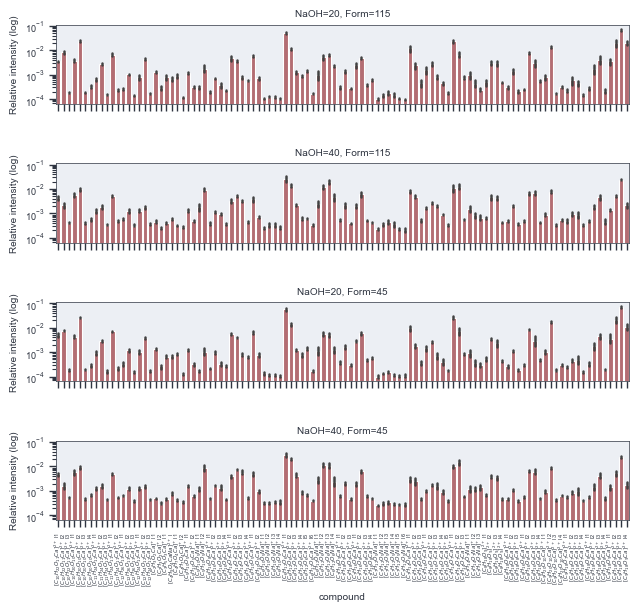

In [4]:
conditions = [(20, 115), (40, 115), (20, 45), (40, 45)]

fig, axes = plt.subplots(4, 1, figsize=(6.3, 6), sharex=True, sharey=True, constrained_layout=True, gridspec_kw={'hspace': 0.25})

# Flatten the axes array for easier indexing
axes = axes.flatten()

for idx, conc in enumerate(conditions):
    filtered_data = df_all.query("NaOH==@conc[0] and Form==@conc[1]").drop(columns=['time', 'NaOH', 'Form'])
    
    # Specify the current axis for the subplot
    ax = axes[idx]
    
    # Create a barplot for the current condition
    sns.barplot(data=filtered_data, ax=ax, color='C0')
    
    # Set the y-axis to log scale
    ax.set_yscale("log")
    
    # ax.set_xticks(np.arange(0, len(filtered_data.columns)), filtered_data.columns, rotation=90)
    # # Rotate x-axis labels by 45 degrees
    
    # Set a title for each subplot based on the condition
    ax.set_title(f'NaOH={conc[0]}, Form={conc[1]}')
    ax.set_ylabel("Relative intensity (log)")
    ax.set_xlabel("")
axes[3].set_xlabel("compound")
plt.xticks(rotation=90, size=4)

save_si("steadystates_reproducibility")
plt.show()
